In [17]:
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

team_box_score = pd.read_csv('2012-18_teamBoxScore.csv')
player_box_score = pd.read_csv('2012-18_playerBoxScore.csv')
standings = pd.read_csv('2012-18_standings.csv')

In [18]:
# This is Linear Regression Exploration 

In [19]:
#First wanted to look for any null values in the dataset

#In the teamBoxScore dataset there are 4 games where the 3rd referee wasn't present, which is rare in the NBA
# but has happened. Only 4 because first and last name were missing
team_box_score.isnull().sum().sort_values(ascending=False).head(5)

offLNm3      4
offFNm3      4
pace         0
teamTREB%    0
teamFT%      0
dtype: int64

In [20]:
# Int playerBoxScore there were 41 missing values as in the games that the referee was missing 
# each player would have a null value for the game under referee
player_box_score.isnull().sum().sort_values(ascending=False).head(5)

offFNm3       41
offLNm3       41
opptDayOff     0
offFNm1        0
playWeight     0
dtype: int64

In [21]:
# The standings data had no null values which was great
standings.isnull().sum().sort_values(ascending=False).head(5)

lpyth16.5    0
gameBack     0
confWin      0
awayLoss     0
awayWin      0
dtype: int64

In [22]:
# I changed all the null values to an empty string '' for style, but the data missing has no value to the model
# we are trying to create. We won't be using the referee names as a feature because it is obvious there is no
# connection to the win ratio of a team

team_box_score.fillna("", inplace=True)
player_box_score.fillna("", inplace=True)

In [23]:
player_box_score

,gmDate,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
0,2012-10-30,19:00,Regular,Price,A.J.,WAS,East,Southeast,Away,Loss,...,1.0,1,1,2,CLE,East,Central,Home,Win,0
1,2012-10-30,19:00,Regular,Ariza,Trevor,WAS,East,Southeast,Away,Loss,...,0.5,1,2,3,CLE,East,Central,Home,Win,0
2,2012-10-30,19:00,Regular,Okafor,Emeka,WAS,East,Southeast,Away,Loss,...,0.5,5,2,7,CLE,East,Central,Home,Win,0
3,2012-10-30,19:00,Regular,Beal,Bradley,WAS,East,Southeast,Away,Loss,...,1.0,0,3,3,CLE,East,Central,Home,Win,0
4,2012-10-30,19:00,Regular,Booker,Trevor,WAS,East,Southeast,Away,Loss,...,0.0,1,0,1,CLE,East,Central,Home,Win,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155708,2018-04-11,10:30,Regular,Sampson,JaKarr,SAC,West,Pacific,Home,Win,...,1.0,0,4,4,HOU,West,Southwest,Away,Loss,1
155709,2018-04-11,10:30,Regular,Hield,Chavano,SAC,West,Pacific,Home,Win,...,0.0,2,3,5,HOU,West,Southwest,Away,Loss,1
155710,2018-04-11,10:30,Regular,Hayes,Nigel,SAC,West,Pacific,Home,Win,...,0.0,1,3,4,HOU,West,Southwest,Away,Loss,1
155711,2018-04-11,10:30,Regular,Carter,Vincent,SAC,West,Pacific,Home,Win,...,0.0,0,3,3,HOU,West,Southwest,Away,Loss,1


In [24]:
# Next I looked at the all the datasets and wanted to see which seasons the statistics were in but no such data was 
# given. All the times were strings and hard to distinguish between seasons. 
print(type(team_box_score['gmDate'].iloc[0]))
print(type(player_box_score['gmDate'].iloc[0]))
print(type(standings['stDate'].iloc[0]))

<class 'str'>
<class 'str'>
<class 'str'>


In [25]:
# Need to convert string time date to datetime object in order to filter by time to get seasons
from datetime import datetime

def date_fixer(dates):
    """
    Transforms string to a datetime object
    Input:
      dates (1D array): vector of string dates
    Output:
      an array of datetime objects
    """
    return datetime.strptime(dates, '%Y-%m-%d')

standings['stDate'] = standings['stDate'].apply(date_fixer)

In [26]:
# Same code as above
team_box_score['gmDate'] = team_box_score['gmDate'].apply(date_fixer)

In [27]:
# Same code as above
player_box_score['gmDate'] = player_box_score['gmDate'].apply(date_fixer)

In [28]:
# Now I am going to use those data time objects in order to group games into their respective seasons.
# Need two different functions because some datasets use "stDate" for game date and other use "gmDate"

# The seasons breakers I found by manually looking at the data and seeing where there were gaps

def nba_season_finder_standings(df, column_title):
    """
    Classifers a datetime object into a respective season
    Input:
      df: a dataframe you want to use
      column_title : the name of the column which contains the datetime object
    Output:
      an array of seasons in NBA
    """
    collect=[]
    for i in df[column_title]:
        if (i.year == 2012 and i.month >= 10) or (i.year == 2013 and i.month <= 5):
            collect+=['2012-2013']
        if (i.year == 2013 and i.month >= 10) or (i.year == 2014 and i.month <= 5):
            collect+=['2013-2014']
        if (i.year == 2014 and i.month >= 10) or (i.year == 2015 and i.month <= 5):
            collect+=['2014-2015']
        if (i.year == 2015 and i.month >= 10) or (i.year == 2016 and i.month <= 5):
            collect+=['2015-2016']
        if (i.year == 2016 and i.month >= 10) or (i.year == 2017 and i.month <= 5):
            collect+=['2016-2017']
        if (i.year == 2017 and i.month >= 10) or (i.year == 2018 and i.month <= 5):
            collect+=['2017-2018']
    return collect


# I will be applying this function to all my datasets
standings['season']= nba_season_finder_standings(standings, 'stDate')
team_box_score['season']= nba_season_finder_standings(team_box_score, 'gmDate')
player_box_score['season']= nba_season_finder_standings(player_box_score, 'gmDate')

In [29]:
# Features 1-2 for this model are going to be personalized scores (one for offense and one for defense). These
# scores will be applied to each team each game.

# This is the list of all offensive and defensive features broken into their respective categories from the 
# teamBoxScore dataset

offensive_features = ["teamPTS", "teamTO", "teamFGM", "teamFG%", "team2PM", "team2P%", "team3PM",
                     "team3P%", "teamFTM", "teamFT%", "teamORB", "teamASST%", "teamTS%", "teamFIC", "teamAR"]

defensive_features = ["opptPTS","teamSTL", "teamBLK", "teamDRB", "teamDREB%", "teamSTL%", "teamBLK%", "teamBLKR", 
                      "teamDrtg"]

In [30]:
#Now I am going to do EDA and explore these metrics to see which ones are going to be the best and most useful in 
# predicting how well a team will do in the season. I will be combining, later on, on these scores for each game 
# to get a season score. I decided to create heatmaps as a way to see which features would be best for my functions.

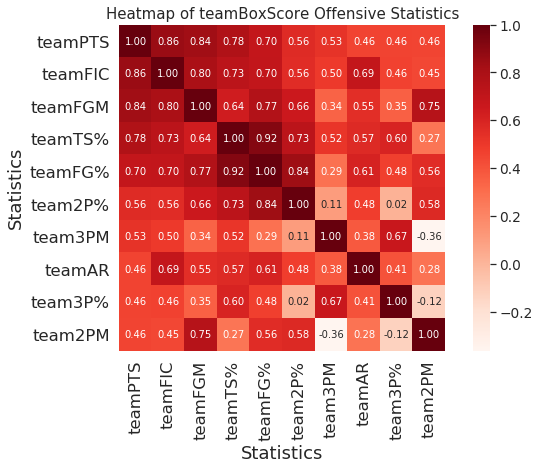

In [31]:
# For offensive features options, I was looking for the statisics that had the highest positive correlations with
# the teamPTS as those metrics would be a good indicator of success in a game.

offensive_data = team_box_score[offensive_features].corr()
k_offensive= 10
cols_offensive = offensive_data.nlargest(k_offensive, "teamPTS")["teamPTS"].index
f, ax = plt.subplots(figsize=(10,6))
cm_offensive = np.corrcoef(team_box_score[offensive_features][cols_offensive].values.T)
sns.set(font_scale=1.25)
hm_offensive = sns.heatmap(cm_offensive, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols_offensive.values, xticklabels=cols_offensive.values, cmap="Reds")

plt.title('Heatmap of teamBoxScore Offensive Statistics')
plt.xlabel('Statistics')
plt.ylabel('Statistics')
plt.show()

In [32]:
# Based on this graph I have found the offensive variables that are most correlated with a team's points that game 
# (indicator of success) by looking at the top row of this heat map. I will use these values and placing respective 
# weights based on correlations to create my own scores. The features chosen are based on the heatmap, yet the weights
# were chosen by us to balance out the difference in percentages & scores and taking into account metrics
# that were more correlated

#Feature 1 --> This is a personalized offensive team score for every game in a season. It is based on weights values
# that were determined from the heatmap as highly positively correlated to a teamPTS (success). The respective weights
# in front of the variables are made based on our team's knowledge of the game and to balance out percentages and 
# number values.

def offensive_teamscore_calculator(df):
    """
    Offensive Score Calculator
    Input:
      df: a dataframe with all statics needed
    Output:
      an array of offensive scores based on assumed weights
    """
    return (3 * df["teamFGM"] + 100 * df["teamFG%"]+ 2 * df["teamAR"]+ 100 * df["team3P%"])

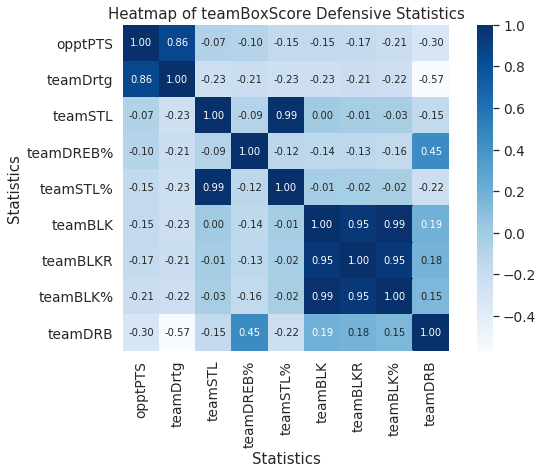

In [33]:
# I did this same process again for all the defensive features given. I was looking for the biggest negative 
# correlations with opptPTS, as if you are doing well in defense you expect the other team to score less. This 
# is not the case for TeamDrtg because it is already with respect to opptpts, so we are looking for positive values

defensive_data = team_box_score[defensive_features].corr()
k_defensive= 10
cols_defensive = defensive_data.nlargest(k_defensive, "opptPTS")["opptPTS"].index
f, ax = plt.subplots(figsize=(10,6))
cm_defensive = np.corrcoef(team_box_score[defensive_features][cols_defensive].values.T)
sns.set(font_scale=1.25)
hm_defensive = sns.heatmap(cm_defensive, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols_defensive.values, xticklabels=cols_defensive.values, cmap="Blues")

plt.title('Heatmap of teamBoxScore Defensive Statistics')
plt.xlabel('Statistics')
plt.ylabel('Statistics')
plt.show()

In [34]:
# Based on this graph I have found the offensive variables that are most negatively correlated with an opponent's
# points that game as that will let us know which scores reduced that opponents pts (success). This isn't for 
# teamDRrtg though because this metric already takes into account opponents' stats while other metrics take in home 
# team stats.

#Feature 2 --> This is a personalized defensive team score for every game in a season. It is based on weights values
# that were determined from the heatmap as highly negatively correlated to a opptPTS (other teams failure). The 
# respective weights in front of the variables are made based on our team's knowledge of the game and to balance out
# percentages and number values.

def defensive_teamscore_calculator(x):
    """
    Defensive Score Calculator
    Input:
      df: a dataframe with all statistics needed
    Output:
      an array of defensive scores based on assumed weights
    """
    return ( 3*x["teamDrtg"] + 11 * x["teamBLK%"] + 7 * x["teamSTL%"]+ (1/2) * x["teamDREB%"])

In [35]:
#Time to apply these scores to every game in teamBoxScore

team_box_score['offensive_score'] = offensive_teamscore_calculator(team_box_score)
team_box_score['defensive_score'] = defensive_teamscore_calculator(team_box_score)
team_box_score

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace,season,offensive_score,defensive_score
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,...,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409,2012-2013,194.2958,554.23970
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,...,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409,2012-2013,221.9844,433.59895
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,...,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832,2012-2013,252.8502,475.24475
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,...,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832,2012-2013,273.0874,495.60655
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,...,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790,2012-2013,235.0576,460.65005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14753,2018-04-11,10:30,Regular,Garretson,Ron,Mott,Rodney,Richardson,Derek,LAC,...,14.7419,0.4421,18.2428,1.4706,47.0588,101.7513,101.7513,2017-2018,244.4896,443.28110
14754,2018-04-11,10:30,Regular,Cutler,Kevin,Kennedy,Bill,Lewis,Eric,UTA,...,9.2142,0.4457,15.1951,1.9000,90.0000,97.6761,97.2708,2017-2018,198.0176,470.33620
14755,2018-04-11,10:30,Regular,Cutler,Kevin,Kennedy,Bill,Lewis,Eric,POR,...,-9.2142,0.3667,13.5788,1.2000,33.3333,97.6761,97.6761,2017-2018,236.9602,488.28405
14756,2018-04-11,10:30,Regular,Tiven,Josh,Orr,J.T.,Foster,Scott,HOU,...,14.1326,0.4471,18.0624,2.0000,54.5455,91.9864,91.6047,2017-2018,178.6538,442.16425


In [36]:
#Now that I have this score for every game, I need to get the teams' total scores for every game that season. So I
# will be grouping and then summing all values. I will save these values for now and merge them later with other data.

team_offensive_defensive_scores = team_box_score.groupby(['season', 'teamAbbr'], 
                                                   as_index=False)[['offensive_score', 'defensive_score']].agg(sum)
team_offensive_defensive_scores

,season,teamAbbr,offensive_score,defensive_score
0,2012-2013,ATL,19225.0102,38017.31115
1,2012-2013,BKN,18089.0864,38673.08025
2,2012-2013,BOS,18601.5572,37383.18695
3,2012-2013,CHA,17204.6952,40571.11400
4,2012-2013,CHI,18181.9310,38080.90665
...,...,...,...,...
175,2017-2018,SA,19097.5530,38911.50270
176,2017-2018,SAC,19063.3550,39170.01990
177,2017-2018,TOR,19899.6184,39353.17485
178,2017-2018,UTA,19036.3232,38822.54225


In [37]:
# Now will be looking into a very famous complex called PER as the 3rd feature

In [38]:
# In this model we are going to use the very famous PER (Player Efficency Rating) metric in order to 
# predict a teams win/loss ratio. This metric was invented by John Hollinger. I am using Bleacher reports 
# linear weights as an estimator for this metric as it is very complex, yet results are very close..
# Link: https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess

#Feature 3 --> PER Ratio measures how effective a single player is in a game using a complex math fromula
# derived from a famous basketball reporter. It takes into account all facets of a player's game and shows
# how effective they were for each minute they played

def PER_formula(df):
    """
    Player Efficency Calculator: PER
    Input:
      df: a dataframe with all statistics needed
    Output:
      an array of PER scores for each player
    """
    try:
    
        PER = (df['playFGM'] * 85.910 + df['playSTL'] * 53.897 + df['play3PM'] * 51.757 + df['playFTM'] * 46.845 + 
           df['playBLK'] * 39.190 + df['playORB'] * 39.190 + df['playAST'] * 34.677 + df['playDRB'] * 14.707 -
           df['playPF'] * 17.174 - (df['playFTA']- df['playFTM'])*20.091 - 
           (df['playFGA']- df['playFGM'])*39.190 - df['playTO'] * 53.897) / df['playMin']
        return PER
    
    except ZeroDivisionError:
        return 0

In [39]:
# Created new column that has this score for every player in each game
PER_player_data = player_box_score

PER_player_data = PER_player_data.groupby(['playLNm','playFNm', 'teamAbbr','season'], as_index=False).agg(sum)

PER_player_data['PER_real'] = PER_player_data.apply(PER_formula, axis=1)

# This is the PER value taking into accout minutes played as PER is a per minute value.
PER_player_data['PER_real_affected'] = PER_player_data['PER_real'] * PER_player_data['playMin'] 
PER_player_data

,playLNm,playFNm,teamAbbr,season,teamDayOff,playMin,playHeight,playWeight,playPTS,playAST,...,play3P%,playFTA,playFTM,playFT%,playORB,playDRB,playTRB,opptDayOff,PER_real,PER_real_affected
0,Abrines,Alejandro,OKC,2016-2017,113,1057,5304,12920,406,40,...,24.2744,49,44,19.9667,18,66,84,117,11.257443,11899.117
1,Abrines,Alejandro,OKC,2017-2018,132,1134,5850,14250,353,28,...,25.1213,46,39,17.1667,26,87,113,144,9.850199,11170.126
2,Acy,Quincy,BKN,2016-2017,49,511,2528,7520,209,18,...,13.9000,57,43,14.7976,18,89,107,59,14.977211,7653.355
3,Acy,Quincy,BKN,2017-2018,127,1362,5530,16450,411,57,...,24.8245,60,49,19.9167,40,217,257,128,9.680579,13184.948
4,Acy,Quincy,DAL,2016-2017,11,48,474,1410,13,0,...,0.3333,3,2,1.0000,2,6,8,7,-0.231500,-11.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,Zipser,Paul,CHI,2016-2017,72,840,3520,9196,240,36,...,10.4641,40,31,13.0834,15,110,125,75,7.983923,6706.495
3320,Zipser,Paul,CHI,2017-2018,96,823,4320,11286,218,46,...,11.7213,26,19,7.8333,13,118,131,100,6.438846,5299.170
3321,Zubac,Ivica,LAL,2016-2017,70,611,3230,9120,284,30,...,0.0000,49,32,14.4167,40,117,157,73,18.401668,11243.419
3322,Zubac,Ivica,LAL,2017-2018,75,412,3655,10320,161,25,...,0.0000,51,39,11.8000,45,77,122,88,17.012677,7009.223


In [40]:
#This function is grouping all the PER values for a team in a season and using only the top 12 men on the roster
# who played the most minutes. In order to account for any trades or random one-off games

#This is for all seasons
def team_PER__calculator(df):
    """
    Team PER calcutor
    Input:
      df: a dataframe with all statics needed
    Output:
      an array grouped PER scores for each team
    """
    def include_crucial_players(x):
        store = x[:12]
        return sum(store)
    
    df=df.sort_values('playMin', ascending=False)
    holder = df.groupby(['teamAbbr','season'], as_index=False)[['PER_real_affected']].agg(include_crucial_players)
    holder['team_PER'] = holder['PER_real_affected']
    holder.drop('PER_real_affected', axis=1, inplace=True)
    return holder

PER_team_data = team_PER__calculator(PER_player_data)

PER_team_data 

,teamAbbr,season,team_PER
0,ATL,2012-2013,287521.830
1,ATL,2013-2014,303077.882
2,ATL,2014-2015,325005.218
3,ATL,2015-2016,317409.595
4,ATL,2016-2017,300824.081
...,...,...,...
175,WAS,2013-2014,293809.210
176,WAS,2014-2015,289699.248
177,WAS,2015-2016,302804.501
178,WAS,2016-2017,334013.317


In [41]:
# Now I will be creating a 4th feature for my model. This is going to be using the players heights and weights to
# calculate BMI. The neat thing about BMI's is that athletes have certain ranges that make them in ideal shape, 
# underweight, overweight, etc. So we can group these BMI's into categories then use OneHotEncoder with these 
# categorical groups

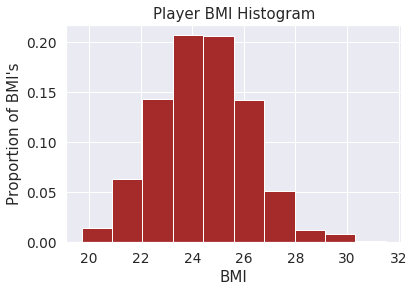

In [42]:
# Look at BMI of each player to see if maybe a team's combined BMI might be better 

def bmi_calculator(height, weight):
    """
    BMI calculator
    Input:
      height: an array of heights
      weight: an array of weights
    Output:
      an array of BMI scores for each player
    """
    return weight/(height**2)

bmi_EDA_players= player_box_score 
bmi_EDA_players['bmi'] = bmi_calculator(player_box_score ['playHeight'], player_box_score ['playWeight']) *703
plt.hist(bmi_EDA_players['bmi'], color='brown', density=True)
plt.title('Player BMI Histogram')
plt.xlabel('BMI')
plt.ylabel("Proportion of BMI's");

In [43]:
# Now need to place into categories based on statistical and health standards. These are not based on
# regular human groups but athletes since they are bigger due to more muscle and muscle weighs more than fat

def bmi_containers(array):
    """
    BMI Category Classifer
    Input:
      array: an array of BMI scores
    Output:
      an array of BMI categorical values 
    """
    collect = []
    for i in array:
        if i < 21:
            collect += ['underweight']
        if i >=21 and i <22.5:
            collect += ['slightly_underweight']
        if i >= 22.5 and i< 25.5:
            collect += ['ideal']
        if i >=25.5 and i <27.5:
            collect += ['slightly_overweight']
        if i >=27.5:
            collect += ['overweight']          
    return collect


bmi_EDA_players['bmi_category'] = bmi_containers(bmi_EDA_players['bmi'])

In [44]:
# Only values that interest us for this feature
bmi_EDA_players = bmi_EDA_players[['teamAbbr', 'season','bmi_category', 'playDispNm']]
bmi_EDA_players

,teamAbbr,season,bmi_category,playDispNm
0,WAS,2012-2013,ideal,A.J. Price
1,WAS,2012-2013,slightly_underweight,Trevor Ariza
2,WAS,2012-2013,slightly_overweight,Emeka Okafor
3,WAS,2012-2013,ideal,Bradley Beal
4,WAS,2012-2013,slightly_overweight,Trevor Booker
...,...,...,...,...
155708,SAC,2017-2018,ideal,JaKarr Sampson
155709,SAC,2017-2018,ideal,Buddy Hield
155710,SAC,2017-2018,overweight,Nigel Hayes
155711,SAC,2017-2018,ideal,Vince Carter


In [45]:
# One-Hot ENCODING USING pd.dummies() on BMI categorized values since categorical variable

one_hot_encoder = pd.get_dummies(bmi_EDA_players['bmi_category'])
bmi_EDA_players = bmi_EDA_players.drop('bmi_category',axis = 1)
bmi_EDA_players = bmi_EDA_players.join(one_hot_encoder)
bmi_EDA_players

,teamAbbr,season,playDispNm,ideal,overweight,slightly_overweight,slightly_underweight,underweight
0,WAS,2012-2013,A.J. Price,1,0,0,0,0
1,WAS,2012-2013,Trevor Ariza,0,0,0,1,0
2,WAS,2012-2013,Emeka Okafor,0,0,1,0,0
3,WAS,2012-2013,Bradley Beal,1,0,0,0,0
4,WAS,2012-2013,Trevor Booker,0,0,1,0,0
...,...,...,...,...,...,...,...,...
155708,SAC,2017-2018,JaKarr Sampson,1,0,0,0,0
155709,SAC,2017-2018,Buddy Hield,1,0,0,0,0
155710,SAC,2017-2018,Nigel Hayes,0,1,0,0,0
155711,SAC,2017-2018,Vince Carter,1,0,0,0,0


In [46]:
# I need to group by players first because each player has the same weight and height throughout the season
# so we can just simplify the dataset. Then I group by team and sum to get total counts of each bmi category
# for each season in the dataframe

team_bmi_data = bmi_EDA_players.groupby(['teamAbbr','season', 'playDispNm'],
                                          as_index= False).agg(lambda x: x.iloc[0])
team_bmi_data = team_bmi_data.groupby(['teamAbbr','season'],as_index= False).agg(sum)
team_bmi_data

,teamAbbr,season,ideal,overweight,slightly_overweight,slightly_underweight,underweight
0,ATL,2012-2013,8,1,8,1,0
1,ATL,2013-2014,7,2,7,2,0
2,ATL,2014-2015,6,1,7,1,1
3,ATL,2015-2016,11,0,4,2,0
4,ATL,2016-2017,14,0,5,1,0
...,...,...,...,...,...,...,...
175,WAS,2013-2014,9,1,3,4,0
176,WAS,2014-2015,11,2,3,2,0
177,WAS,2015-2016,12,1,4,2,0
178,WAS,2016-2017,13,0,2,3,0


In [47]:
#link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3796832/
# This article gave us insight into some other features that are good at predicting a team win/loss ratio in a
# season. So we chose the teams' total steals and fouls in a season as 2 more features to include in our model

season_team_fouls= list(player_box_score.groupby(['teamAbbr', 'season'], as_index= False).agg(sum)['playPF'])
season_team_steals= list(player_box_score.groupby(['teamAbbr', 'season'], as_index= False).agg(sum)['playSTL'])

In [48]:
# Exploring team divisional categorical data
team_box_score['teamDiv'].value_counts()

Pacific      2460
Northwest    2460
Southeast    2460
Southwest    2460
Atlantic     2459
Central      2459
Name: teamDiv, dtype: int64

In [49]:
# Next want to see whether the Divison that a team plays in affects their win ratio as some leagues are stacked 
# compared to others, and everyone plays everyone

team_divison_data = team_box_score[['teamAbbr', 'season','teamDiv']]
team_divison_data

,teamAbbr,season,teamDiv
0,WAS,2012-2013,Southeast
1,CLE,2012-2013,Central
2,BOS,2012-2013,Atlantic
3,MIA,2012-2013,Southeast
4,DAL,2012-2013,Southwest
...,...,...,...
14753,LAC,2017-2018,Pacific
14754,UTA,2017-2018,Northwest
14755,POR,2017-2018,Northwest
14756,HOU,2017-2018,Southwest


In [50]:
# Created One Hot Encoding Of division

one_hot_encoder_divison = pd.get_dummies(team_divison_data['teamDiv'])
team_divison_data = team_divison_data.drop('teamDiv',axis = 1)
team_divison_data = team_divison_data.join(one_hot_encoder_divison)

In [51]:
# This could make sure each team per season is in one divisonal league

team_divison_data = team_divison_data.groupby(['teamAbbr','season'], as_index=False).agg(max)
team_divison_data

,teamAbbr,season,Atlantic,Central,Northwest,Pacific,Southeast,Southwest
0,ATL,2012-2013,0,0,0,0,1,0
1,ATL,2013-2014,0,0,0,0,1,0
2,ATL,2014-2015,0,0,0,0,1,0
3,ATL,2015-2016,0,0,0,0,1,0
4,ATL,2016-2017,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
175,WAS,2013-2014,0,0,0,0,1,0
176,WAS,2014-2015,0,0,0,0,1,0
177,WAS,2015-2016,0,0,0,0,1,0
178,WAS,2016-2017,0,0,0,0,1,0


In [52]:
#Now I want to look at how many minutes total a team starters played in a season. Starters are usually the better
# players so adding this up can tell us essentially how much the team's best players are playing and maybe that
# can give us another feature in our model
starters_players = player_box_score[player_box_score['playStat'] == 'Starter']
player_starter_minutes = starters_players.groupby(['teamAbbr', 'season'], as_index=False).agg(sum)

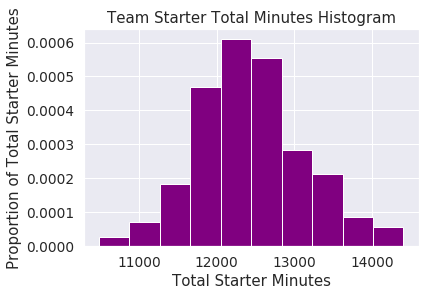

In [53]:
# Now we only want the total minutes column. Lets see a distribution of each team's total minutes by starters
plt.hist(player_starter_minutes['playMin'], color='purple', density=True)
plt.title('Team Starter Total Minutes Histogram')
plt.xlabel('Total Starter Minutes')
plt.ylabel("Proportion of Total Starter Minutes");

In [54]:
player_starter_minutes = player_starter_minutes[['teamAbbr','season','playMin']]
player_starter_minutes.rename(columns = {'playMin': 'starter_min'}, inplace=True)
player_starter_minutes

,teamAbbr,season,starter_min
0,ATL,2012-2013,13172
1,ATL,2013-2014,12956
2,ATL,2014-2015,12756
3,ATL,2015-2016,12390
4,ATL,2016-2017,12409
...,...,...,...
175,WAS,2013-2014,13749
176,WAS,2014-2015,12304
177,WAS,2015-2016,12630
178,WAS,2016-2017,13567


In [55]:
# Now I have created all the features that I will think about using in the model. I need to calculate the value that
# I am trying to predict based on these features. This is the win ratio for every team each season.

In [56]:
# This code calculates the win ratio for each team, every season
win_ratio_data= standings.groupby(['teamAbbr', 'season'], as_index=False)[['gameWon', 'gameLost']].agg(max)
win_ratio_data['win_ratio'] = win_ratio_data['gameWon']/(win_ratio_data['gameWon']+ win_ratio_data['gameLost'])*100
win_ratio_data.sort_values(by='season', ascending=True, inplace=True)
win_ratio_data

,teamAbbr,season,gameWon,gameLost,win_ratio
0,ATL,2012-2013,44,38,53.658537
30,CLE,2012-2013,24,58,29.268293
120,OKC,2012-2013,60,22,73.170732
156,SAC,2012-2013,28,54,34.146341
138,PHO,2012-2013,25,57,30.487805
...,...,...,...,...,...
125,OKC,2017-2018,48,34,58.536585
131,ORL,2017-2018,25,57,30.487805
137,PHI,2017-2018,52,30,63.414634
71,IND,2017-2018,48,34,58.536585


In [57]:
# I am now merging all my datasets and features that I have created into one condensed dataframe for my model
# to use. 
from sklearn.preprocessing import StandardScaler


# Seaonsal Data
full_seasonal_data = PER_team_data.merge(win_ratio_data, how = "left")
full_seasonal_data.drop(['gameWon','gameLost'], axis=1, inplace=True)
full_seasonal_data['team_PER_log']= np.log(full_seasonal_data['team_PER'])
full_seasonal_data = full_seasonal_data.merge(team_offensive_defensive_scores, how='left', on = ['teamAbbr','season'])
full_seasonal_data = full_seasonal_data.merge(team_bmi_data, how='left', on =['teamAbbr','season'])
full_seasonal_data = full_seasonal_data.merge(team_divison_data, how = 'left', on = ['teamAbbr','season'])
full_seasonal_data = full_seasonal_data.merge(player_starter_minutes, how = 'left', on = ['teamAbbr','season'])

full_seasonal_data['team_steals'] = season_team_steals
full_seasonal_data['team_fouls'] = season_team_fouls


full_seasonal_data

,teamAbbr,season,team_PER,win_ratio,team_PER_log,offensive_score,defensive_score,ideal,overweight,slightly_overweight,...,underweight,Atlantic,Central,Northwest,Pacific,Southeast,Southwest,starter_min,team_steals,team_fouls
0,ATL,2012-2013,287521.830,53.658537,12.569054,19225.0102,38017.31115,8,1,8,...,0,0,0,0,0,1,0,13172,664,1473
1,ATL,2013-2014,303077.882,46.341463,12.621745,18987.8414,37988.09410,7,2,7,...,0,0,0,0,0,1,0,12956,680,1577
2,ATL,2014-2015,325005.218,73.170732,12.691597,19522.8476,38353.06170,6,1,7,...,1,0,0,0,0,1,0,12756,744,1457
3,ATL,2015-2016,317409.595,58.536585,12.667948,19274.0464,38863.97200,11,0,4,...,0,0,0,0,0,1,0,12390,749,1570
4,ATL,2016-2017,300824.081,52.439024,12.614281,18738.2898,38421.10560,14,0,5,...,0,0,0,0,0,1,0,12409,670,1491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,WAS,2013-2014,293809.210,53.658537,12.590686,19289.4014,38143.24115,9,1,3,...,0,0,0,0,0,1,0,13749,668,1675
176,WAS,2014-2015,289699.248,56.097561,12.576599,19178.4930,37338.79700,11,2,3,...,0,0,0,0,0,1,0,12304,601,1707
177,WAS,2015-2016,302804.501,50.000000,12.620843,19404.4046,37827.24200,12,1,4,...,0,0,0,0,0,1,0,12630,709,1708
178,WAS,2016-2017,334013.317,59.756098,12.718936,20028.8666,38810.80110,13,0,2,...,0,0,0,0,0,1,0,13567,695,1745


In [58]:
# Now after getting all the features into once place we need to keep track of conference so we will merge this in.
# Also, need the rank to see how good our predictor is 

#Get Conference Data
conference_data = team_box_score.groupby(['teamAbbr', 'teamConf'], 
                                     as_index=False).agg(lambda x: x.iloc[0])[['teamAbbr', 'teamConf']]

#Get each team season rank
season_rank_holder = standings[['teamAbbr','season','stDate','rank']].groupby(['teamAbbr','season'],
                                                                                      as_index=False).agg(max)
season_rank_holder = season_rank_holder.drop('rank', axis=1)
season_rank = standings[['teamAbbr','season','stDate', 'rank']].merge(season_rank_holder, how = 'right', 
                                                                              on = ['teamAbbr','season','stDate'])
season_rank.drop('stDate', axis=1 ,inplace=True)


# Combines all dataframes
full_seasonal_data = full_seasonal_data.merge(conference_data, how = 'left')
full_seasonal_data = full_seasonal_data.merge(season_rank, how ='left', on= ['teamAbbr','season'])

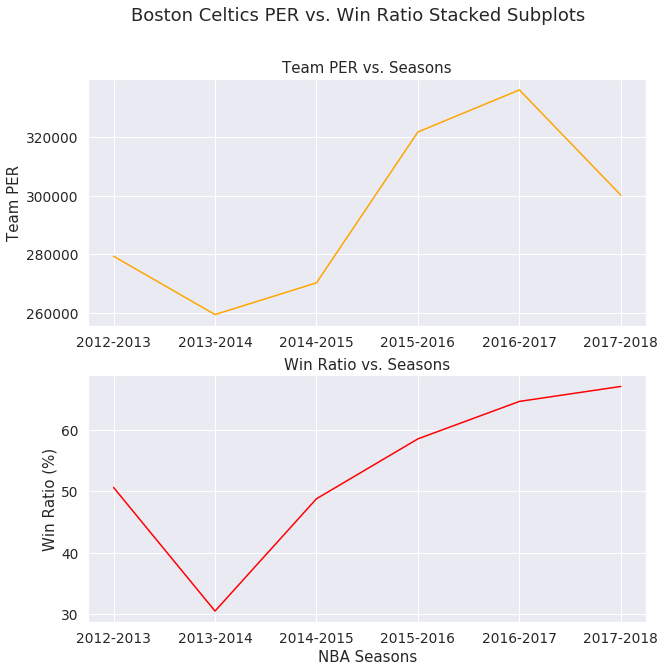

In [59]:
# Graphic shows a specfic team win/Ratio and team per overtime (seasons) --> EDA
def graphic_maker(df,team):
    """
    PER vs Win Ratio Graphic creator
    Input:
      df: a dataframe of statics
      team: 3 letter uppercase ticker for a NBA team
    Output:
      a subplot showing PER and Win Ratio across all seasons
    """
    fig, axs = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Boston Celtics PER vs. Win Ratio Stacked Subplots')
    new_df = df[df['teamAbbr']==team]
    axs[0].plot(new_df['season'], new_df['team_PER'], color = 'orange' )
    axs[0].set_title('Team PER vs. Seasons')
    axs[0].set_ylabel('Team PER')
    axs[1].plot(new_df['season'], new_df['win_ratio'], color='red')
    axs[1].set_title('Win Ratio vs. Seasons')
    axs[1].set_ylabel('Win Ratio (%)')
    axs[1].set_xlabel('NBA Seasons')
    return None 

graphic_maker(full_seasonal_data, 'BOS')

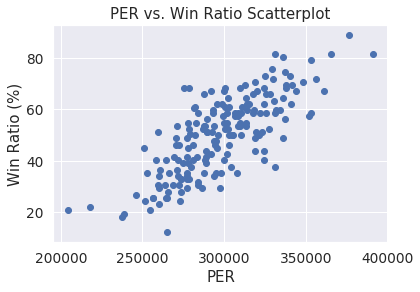

In [60]:
# Looking at the feature to see the correlation with the value I am predicitng

x= full_seasonal_data['team_PER']
y=full_seasonal_data['win_ratio']
plt.title('PER vs. Win Ratio Scatterplot')
plt.xlabel('PER')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

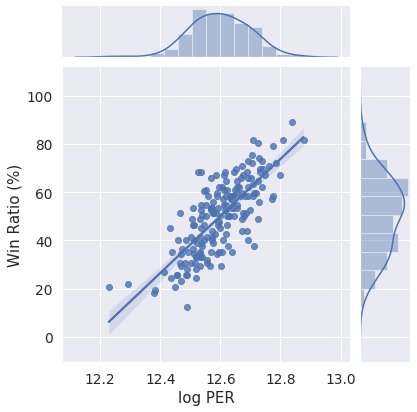

In [61]:
sns.jointplot(full_seasonal_data['team_PER_log'],full_seasonal_data['win_ratio'], kind='regplot')
plt.xlabel('log PER')
plt.ylabel("Win Ratio (%)");

In [62]:
# Look into potential outliers seen in the graph below
# Looks like NY in Year 2014-2015 and Philly 2014-2015 don't follow the trend __> Outliers on the bottom left# 
# Knicks set record franchise loss of 65, original was 60 that year -Iman Shumpert and J.R. Smith traded to CAVS 
# MIDSEASON Philly 3rd worst record in franchise histroy --> hoping on star Joel Embid but got injured perseaon

full_seasonal_data.sort_values(['team_PER', 'win_ratio'], ascending=True).head(2)

,teamAbbr,season,team_PER,win_ratio,team_PER_log,offensive_score,defensive_score,ideal,overweight,slightly_overweight,...,Central,Northwest,Pacific,Southeast,Southwest,starter_min,team_steals,team_fouls,teamConf,rank
116,NY,2014-2015,204626.320,20.731707,12.228941,17818.1028,39007.05570,12,0,6,...,0,0,0,0,0,11601,575,1768,East,15
134,PHI,2014-2015,218133.179,21.951220,12.292861,16783.1316,40101.41345,18,0,3,...,0,0,0,0,0,11830,789,1778,East,14


In [63]:
# Remove outliers index 116 & 134
removers = [116, 134]
full_seasonal_data_no_outliers = full_seasonal_data.drop([116, 134])

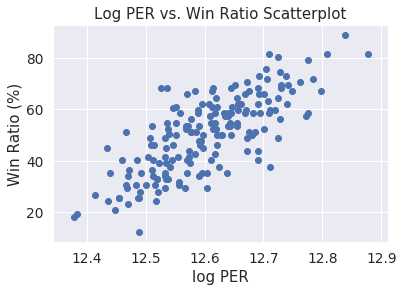

In [64]:
# Removed Outliers
x= full_seasonal_data_no_outliers['team_PER_log']
y=full_seasonal_data_no_outliers['win_ratio']
plt.title('Log PER vs. Win Ratio Scatterplot')
plt.xlabel('log PER')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

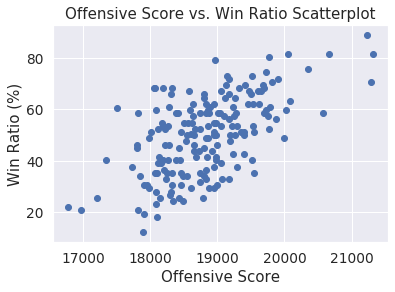

In [65]:
x= full_seasonal_data['offensive_score']
y=full_seasonal_data['win_ratio']
plt.title('Offensive Score vs. Win Ratio Scatterplot')
plt.xlabel('Offensive Score')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

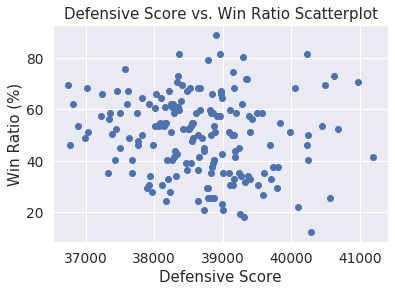

In [66]:
x= full_seasonal_data['defensive_score']
y=full_seasonal_data['win_ratio']
plt.title('Defensive Score vs. Win Ratio Scatterplot')
plt.xlabel('Defensive Score')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

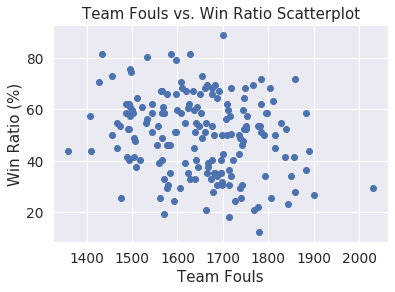

In [67]:
x= full_seasonal_data['team_fouls']
y=full_seasonal_data['win_ratio']
plt.title('Team Fouls vs. Win Ratio Scatterplot')
plt.xlabel('Team Fouls')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

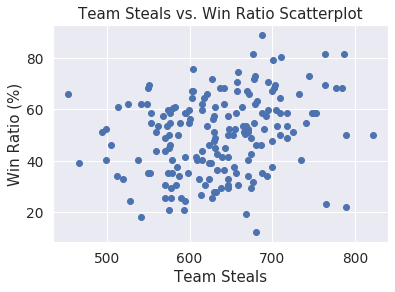

In [68]:
x= full_seasonal_data['team_steals']
y=full_seasonal_data['win_ratio']
plt.title('Team Steals vs. Win Ratio Scatterplot')
plt.xlabel('Team Steals')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

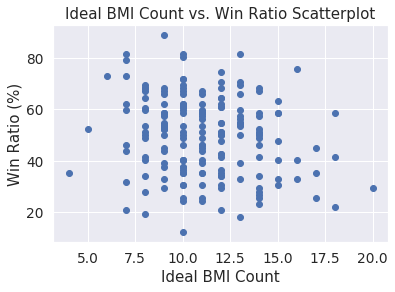

In [69]:
# Very weird--shows the more ideal the less likely to win. Very rough linear relationship but you can see
# ***UNEXPECTED
x= full_seasonal_data['ideal']
y=full_seasonal_data['win_ratio']
plt.title('Ideal BMI Count vs. Win Ratio Scatterplot')
plt.xlabel('Ideal BMI Count')
plt.ylabel("Win Ratio (%)")
plt.scatter(x, y);

In [70]:
# I now need to standardize all my values to make the model coefficent more realistic and interpretable

# Steps to use to standardize data once done

team_divison_categories = ['Atlantic','Central', 'Northwest', 'Pacific', 'Southeast']

non_standarize_features = full_seasonal_data[['win_ratio', 'teamAbbr', 'season', 'teamConf', 'rank','Atlantic',
                                              'Central', 'Northwest', 'Pacific', 'Southeast' ]]
standarize_values = full_seasonal_data.drop(['win_ratio', 'teamAbbr', 'season', 'teamConf', 'rank', 'Atlantic',
                                             'Central', 'Northwest', 'Pacific', 'Southeast'], axis=1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(standarize_values)

standardized_dataframe = pd.DataFrame(x_scaled)
full_seasonal_data = pd.concat([standardized_dataframe, non_standarize_features], axis=1)
full_seasonal_data.rename(columns={0: "team_PER", 1: "log_team_PER", 2: "offensive_score", 3: "defensive_score",
                               4: "ideal", 5: "overweight", 6:"slightly_overweight", 7: "slightly_underweight",
                                8: "underweight" , 9: 'starter_min', 10: "team_steals", 11: "team_fouls" }, 
                          inplace=True)
full_seasonal_data

,team_PER,log_team_PER,offensive_score,defensive_score,ideal,overweight,slightly_overweight,slightly_underweight,underweight,starter_min,...,win_ratio,teamAbbr,season,teamConf,rank,Atlantic,Central,Northwest,Pacific,Southeast
0,-0.346772,-0.301122,0.534968,-0.769751,-1.159785,0.290409,2.108928,-0.730815,-0.519267,-0.447214,...,53.658537,ATL,2012-2013,East,6,0,0,0,0,1
1,0.182454,0.228990,0.210889,-0.803909,-1.534581,1.535019,1.549036,-0.031099,-0.519267,-0.447214,...,46.341463,ATL,2013-2014,East,8,0,0,0,0,1
2,0.928435,0.931748,0.941948,-0.377220,-1.909377,0.290409,1.549036,-0.730815,1.092250,-0.447214,...,73.170732,ATL,2014-2015,East,1,0,0,0,0,1
3,0.670027,0.693829,0.601974,0.220093,-0.035397,-0.954201,-0.130642,-0.031099,-0.519267,-0.447214,...,58.536585,ATL,2015-2016,East,3,0,0,0,0,1
4,0.105778,0.153895,-0.130111,-0.297669,1.088990,-0.954201,0.429251,-0.730815,-0.519267,-0.447214,...,52.439024,ATL,2016-2017,East,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.132871,-0.083489,0.622955,-0.622525,-0.784989,0.290409,-0.690534,1.368335,-0.519267,-0.447214,...,53.658537,WAS,2013-2014,East,5,0,0,0,0,1
176,-0.272695,-0.225218,0.471405,-1.563013,-0.035397,1.535019,-0.690534,-0.031099,-0.519267,-0.447214,...,56.097561,WAS,2014-2015,East,5,0,0,0,0,1
177,0.173153,0.219911,0.780101,-0.991964,0.339399,0.290409,-0.130642,-0.031099,-0.519267,-0.447214,...,50.000000,WAS,2015-2016,East,10,0,0,0,0,1
178,1.234895,1.206806,1.633397,0.157930,0.714194,-0.954201,-1.250427,0.668618,-0.519267,-0.447214,...,59.756098,WAS,2016-2017,East,4,0,0,0,0,1


In [72]:
# Look at different correlations of final data before creating model
full_seasonal_data.drop('rank', axis=1).corr()

,team_PER,log_team_PER,offensive_score,defensive_score,ideal,overweight,slightly_overweight,slightly_underweight,underweight,starter_min,team_steals,team_fouls,12,win_ratio,Atlantic,Central,Northwest,Pacific,Southeast
team_PER,1.000000,0.996938,0.813202,0.141654,-0.258983,-0.203338,-0.104160,0.002075,0.227913,0.082845,0.122925,0.292398,-0.214048,0.769673,-0.180492,-0.083852,0.132887,0.097353,-0.048741
log_team_PER,0.996938,1.000000,0.802759,0.122972,-0.260814,-0.196389,-0.104160,-0.006714,0.213486,0.083959,0.127584,0.279529,-0.221773,0.769718,-0.188289,-0.073205,0.133338,0.087498,-0.043303
offensive_score,0.813202,0.802759,1.000000,0.142864,-0.044577,-0.209698,-0.081982,-0.058092,0.237154,0.098440,-0.046515,0.277204,-0.160497,0.596942,-0.175619,-0.092344,-0.003872,0.173650,-0.000255
defensive_score,0.141654,0.122972,0.142864,1.000000,-0.045182,-0.064484,-0.163171,0.343845,0.048575,0.051921,-0.171352,0.402283,0.174146,-0.132890,-0.047504,-0.141149,0.139356,0.086361,-0.088985
ideal,-0.258983,-0.260814,-0.044577,-0.045182,1.000000,-0.077832,-0.406828,-0.122028,-0.196222,0.151784,-0.129422,-0.109594,0.017822,-0.185763,0.112674,0.073564,-0.239315,-0.015830,-0.082876
overweight,-0.203338,-0.196389,-0.209698,-0.064484,-0.077832,1.000000,0.092139,-0.102247,-0.049771,0.074214,0.043873,0.029314,0.133240,-0.163451,-0.055661,0.092768,-0.148428,0.074214,-0.037107
slightly_overweight,-0.104160,-0.104160,-0.081982,-0.163171,-0.406828,0.092139,1.000000,-0.065004,0.047453,-0.041732,-0.033434,0.057664,0.075522,0.012840,0.075117,-0.066771,-0.008346,0.008346,0.033386
slightly_underweight,0.002075,-0.006714,-0.058092,0.343845,-0.122028,-0.102247,-0.065004,1.000000,-0.128909,0.184277,0.006419,0.234863,0.143211,-0.107550,-0.066061,-0.118215,0.121692,-0.128646,0.006954
underweight,0.227913,0.213486,0.237154,0.048575,-0.196222,-0.049771,0.047453,-0.128909,1.000000,0.032031,0.039953,0.081127,-0.100985,0.146974,-0.136131,-0.136131,0.272261,0.056054,-0.088085
starter_min,0.082845,0.083959,0.098440,0.051921,0.151784,0.074214,-0.041732,0.184277,0.032031,1.000000,-0.077376,0.124196,-0.083485,0.191275,-0.200000,-0.200000,-0.200000,-0.200000,-0.200000


In [73]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual-predicted)**2))

In [74]:
# References for keeping columns in model
features = ["offensive_score", "defensive_score", 'team_PER', 'team_fouls', 'team_steals', "starter_min"]

# ["offensive_score", "defensive_score", 'team_PER', 'team_fouls','team_steals', "starter_min"]

train3 = season_2012_2015_data = full_seasonal_data[full_seasonal_data['season'].isin
                                                    (['2012-2013', '2013-2014', '2014-2015','2015-2016', '2016-2017'])]
test3 = season_2012_2015_data = full_seasonal_data[full_seasonal_data['season'].isin
                                                    (['2017-2018'])]

X_train_3 = train3[features]
Y_train_3 = train3['win_ratio']


X_test_3 = test3[features]
Y_test_3 = test3['win_ratio']

In [75]:
# THIS MODEL For all Seasonal 
## Use Ridge Regression as we didn't want to overfit the data
from sklearn import linear_model as lm
from sklearn.model_selection import KFold

#The ones we are actually using in model based on all testing models
features = ["offensive_score" , "defensive_score", "team_PER",'team_fouls', 'team_steals']


win_linear_model_season = lm.Ridge()
win_linear_model_season.fit(X_train_3, Y_train_3)
Y_fitted_win_season_train = win_linear_model_season.predict(X_train_3)
training_error_win_season = rmse(Y_train_3,Y_fitted_win_season_train)

def compute_CV_error(model, X_train, Y_train):
    """
    Cross Validation Error Calculator
    Input:
      model: a model created from Sklearn package
      X_train: the feature matrix (dataframe)
      Y_train: an array of values you wanted to predict

    Output:
      a single error value based on cross validation
    """
    kf = KFold(n_splits=5)
    validation_errors = []
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        model.fit(split_X_train, split_Y_train)
        error = rmse(split_Y_valid, model.predict(split_X_valid))
        validation_errors.append(error)
    return np.mean(validation_errors)
                                                                             

cross_validation_error= compute_CV_error(win_linear_model_season, X_train_3, Y_train_3)


print("RMSE Traning Error:", training_error_win_season)
print("Cross Validation Error:", cross_validation_error)

RMSE Traning Error: 8.474353737402431
Cross Validation Error: 8.982266742693007


/srv/conda/envs/data100/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 1080x1080 with 0 Axes>

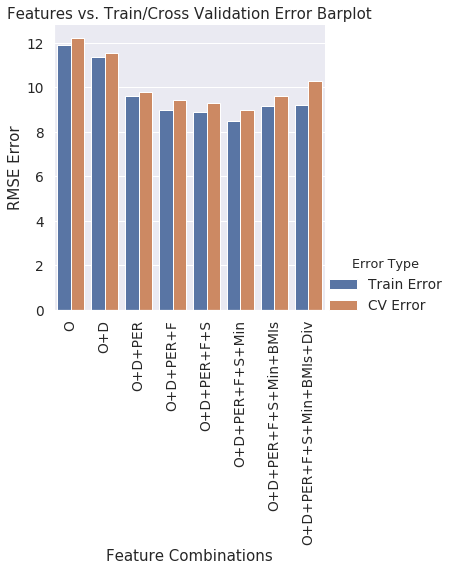

In [76]:
titles_errors= ['O','O','O+D','O+D', 'O+D+PER','O+D+PER', 'O+D+PER+F', 'O+D+PER+F', 'O+D+PER+F+S', 
                'O+D+PER+F+S', 'O+D+PER+F+S+Min', 'O+D+PER+F+S+Min','O+D+PER+F+S+Min+BMIs', 'O+D+PER+F+S+Min+BMIs', 
                'O+D+PER+F+S+Min+BMIs+Div','O+D+PER+F+S+Min+BMIs+Div']
                
type_of_error = ['Train Error', 'CV Error', 'Train Error', 'CV Error', 'Train Error', 'CV Error', 
                 'Train Error', 'CV Error', 'Train Error', 'CV Error', 'Train Error', 'CV Error', 
                 'Train Error', 'CV Error', 'Train Error', 'CV Error']
error_values = [11.89,12.197,11.37,11.558, 9.6, 9.8, 8.97, 9.432, 8.9, 9.3, 8.47, 8.98, 9.15, 9.6, 9.2, 10.3]

model_accuracies= {'Features': titles_errors, 'Error Type': type_of_error , 'Error Values': error_values}
model_score = pd.DataFrame(model_accuracies)
plt.figure(figsize=(15,15))
chart = sns.factorplot(x='Features', y='Error Values', hue='Error Type', data=model_score, kind='bar')
chart.set_xticklabels(rotation=90)
plt.title('Features vs. Train/Cross Validation Error Barplot')
plt.xlabel('Feature Combinations')
plt.ylabel('RMSE Error');

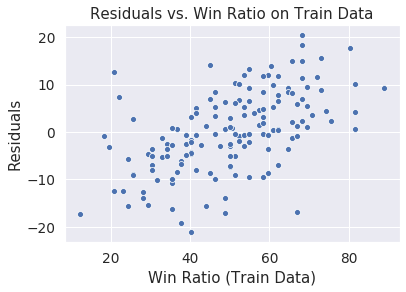

In [77]:
# Residual Plot of predicting a team win ratio based on stats

residuals_win_season = Y_train_3  - Y_fitted_win_season_train
ax = sns.scatterplot(Y_train_3 , residuals_win_season)
ax.set_xlabel('Win Ratio (Train Data)')
ax.set_ylabel('Residuals')
ax.set_title("Residuals vs. Win Ratio on Train Data");

In [78]:
# After doing all this modeling and reducing the CV error, we finally wanted to see how good our model was 
# So we tested the Real Error

Y_fitted_win_season_test = win_linear_model_season.predict(X_test_3)
test_error_win_season = rmse(Y_test_3,Y_fitted_win_season_test)
print("RMSE Test Error:", test_error_win_season)

RMSE Test Error: 9.06206223082339


In [79]:
# Use 2012-2017 season data to predict the rankings of 2017-2018

In [80]:
##Season Data
season_2017_2018_data = full_seasonal_data[full_seasonal_data['season']=='2017-2018']
season_2012_2017_data = full_seasonal_data[full_seasonal_data['season'].isin(
    ['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017'])]
                                          

# Functions that will predict each team's rank (based on conference) and compare to their actual rank that season
features = ["offensive_score", "defensive_score", "team_PER",'team_fouls', 'team_steals', "starter_min" ]
season_predictor_linear_model= lm.Lasso()
season_predictor_linear_model.fit(X_train_3 , Y_train_3)

def rank_predictor_conference(season_data, conf):
    """
    Season Rank Predictor 
    Input:
      season_data: the grouped data from a respective season in NBA
      conf: the conference the team was in (West/East)
    Output:
      a dataframe showing the predicted rank versus the real rank
    """
    predicted_values = season_predictor_linear_model.predict(season_data[features])
    formatter= {'Predicted': predicted_values, 'Real': season_data['win_ratio'], 
    'teamAbbr' : season_data['teamAbbr'], 'real rank': season_data['rank'],
    'conf': season_data['teamConf'] }
    new_dataframe = pd.DataFrame(formatter)
    new_dataframe = new_dataframe.sort_values('Predicted', ascending=False)
    assigned_ranks = list(np.arange(1,16,1))
    conf = new_dataframe[new_dataframe['conf']== conf]
    conf['predicted rank'] = assigned_ranks
    conf.drop('conf', axis=1, inplace=True)
    conf.rename(columns = {'Predicted': 'Predicted Win Ratio', 'Real': 'Real Win Ratio', 
                          'teamAbbr': 'Team', 'real rank': 'Real Rank', 
                           'predicted rank': 'Predicted Rank' }, inplace=True)
    return conf

In [81]:
# West Conference 2017-2018
rank_predictor_conference(season_2017_2018_data, 'West').head(8)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Predicted Win Ratio,Real Win Ratio,Team,Real Rank,Predicted Rank
65,74.984217,79.268293,HOU,1,1
113,72.215724,58.536585,NO,4,2
107,68.154013,57.317073,MIN,7,3
47,62.115487,56.097561,DEN,9,4
59,61.025031,70.731707,GS,2,5
125,59.740421,58.536585,OKC,4,6
155,57.358013,57.317073,SA,7,7
149,56.865247,59.756098,POR,3,8


In [82]:
# East Conference 2017-2018
rank_predictor_conference(season_2017_2018_data, 'East').head(8)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/data100/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Predicted Win Ratio,Real Win Ratio,Team,Real Rank,Predicted Rank
167,69.603381,71.951220,TOR,1,1
137,63.456115,63.414634,PHI,3,2
179,62.045935,52.439024,WAS,8,3
71,60.260426,58.536585,IND,5,4
23,58.912558,43.902439,CHA,10,5
17,55.164034,67.073171,BOS,2,6
95,53.419484,53.658537,MIA,6,7
53,52.194766,47.560976,DET,9,8


In [83]:
# As we can see, the model does a pretty good job predictng teams in the top ten. There are several cases where that 
#isn't true, but in most cases the teams are within +-3 ranks of what they had in reality.

# Not as effective in Eastern conference maybe because the teams are more defensive focused and our data features
# take into account a lot more offensive statistics

In [84]:
# Overall, by choosing our features we were able to create the best possible Ridge regression model, basing it
# on 5 seasons of data, to predict the ranking of the the 2017-2018 season for each team.